### Tutorial #6: Applying Machine Learning Methods to Temporal Dimensions of EEG Data

In this tutorial, same classification tasks in last two tutorails will be examined on temporal dimensions of eeg data.

In this strategy, selected model will be fitted to each time instance and performance of the model at each time instance will be evaluated on the same time instance in new epochs. 

SlidingEstimator in MNE package is provided for this purpose. It takes the model and optionally a scoring function as parameters to create a sliding estimator. After having created a sliding estimator, it can be fitted to the data, scored the estimator on each task or made predictions on new epochs.

In [2]:
# For elimiating warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore
from mne.decoding import Vectorizer

from os.path import isfile, join
from os import listdir
import numpy as np
import statistics

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

As in the previous tutorials, participants' data are concatenated for forming the dataset required for group-level analysis.  

In [4]:
#Load Dataset
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]
#files = files[:10]
ids = [int(f[-6:-4]) for f in files]

numberOfEpochs = np.zeros((len(ids), 3))
# Read the EEG epochs:
epochs_all_UN, epochs_all_UP, epochs_all_NP = [], [], []
for f in range(len(files)):
    epochs = mne.read_epochs(files[f], verbose=False)
    epochs_UN = epochs['FU', 'FN']
    epochs_UP = epochs['FU', 'FP']
    epochs_NP = epochs['FN', 'FP']
    numberOfEpochs[f,0] = int(len(epochs_UN.events))
    numberOfEpochs[f,1] = int(len(epochs_UP.events))
    numberOfEpochs[f,2] = int(len(epochs_NP.events))
    UN, UP, NP = [ids[f]], [ids[f]], [ids[f]]
    UN.append(epochs_UN)
    UP.append(epochs_UP)
    NP.append(epochs_NP)
    epochs_all_UN.append(UN)
    epochs_all_UP.append(UP)
    epochs_all_NP.append(NP)

epochs_all_UN = np.array(epochs_all_UN)
epochs_all_UP = np.array(epochs_all_UP)
epochs_all_NP = np.array(epochs_all_NP)

After having the dataset; data, labels and ids(participant ids) are separated by the folowing function.  

In [5]:
def getData_labels(epochs):
    data, labels, ids = [], [], []
    for p in epochs:
        tmp_epoch = p[1]
        tmp_labels = tmp_epoch.events[:,-1]
        labels.extend(tmp_labels)
        tmp_id = p[0]
        ids.extend([tmp_id]*len(tmp_labels))        
        data.extend(tmp_epoch.get_data())
        
    data = np.array(data)
    labels = np.array(labels)
    ids = np.array(ids)
    return data, labels, ids

### Task #1: Classification of Unpleasant and Pleasant Events

Before starting the model building phase, data should be checked if it contains an invalid value which can be plus/minus infinite or NaN because python's sklearn package cannot handle those values while building models. If the following cell returns "Nan or inifinite is detedted!", you need to check your dataset before moving the next step.
Note that, it may occur that the data contains no NaN or infinite value but sklearn may still give error claiming the opposite. The reason for this error is that there are some values in your dataset which have higher precision than float64 or float32 (depending your preferance while reading data at the beginning) can handle. To fix this issue you can cast your values to float64 or float32 while reading the dataset.

In [6]:
#Preparing dataset
data_UP, labels_UP, ids_UP = getData_labels(epochs_all_UP)
if np.isfinite(data_UP).all() == True and np.isnan(data_UP).any() == False:
    print('Data does not contain nan or infinite value')
else:
    print('Nan or inifininte is detected!')

Data does not contain nan or infinite value


In [15]:
clf_UP = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_UP = SlidingEstimator(clf_UP, scoring='accuracy') 
if np.isfinite(data_UP).all() == True and np.isnan(data_UP).any() == False:
    CV_score_time = cross_val_multiscore(sl_UP, data_UP, labels_UP, cv=3)
    print('Cross validation scores:\n {}'.format(CV_score_time))
else:
    print('Input contains NaN or infinity!')

[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
Cross validation scores:
 [[0.4408078  0.44498607 0.44428969 ... 0.43001393 0.43175487 0.43593315]
 [0.45191638 0.44041812 0.44006969 ... 0.44181185 0.44181185 0.44634146]
 [0.44979079 0.44874477 0.45048815 ... 0.4539749  0.45292887 0.45048815]]


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

def plotCVScores(times, CV_score_time):
    fig, ax = plt.subplots()
    fig.suptitle('CV Scores')
    ax.plot(times, CV_score_time.T)
    plt.xlabel('Time')
    plt.ylabel('Mean CV Accuracy')
    plt.show()


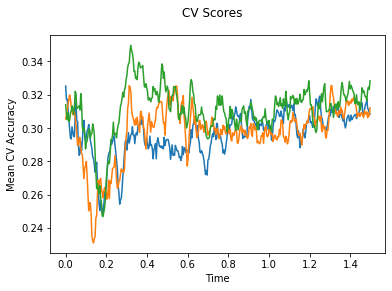

In [18]:
plotCVScores(epochs_UP.times, CV_score_time)

### Task #2: Classification of Unpleasant and Neutral Events

In [10]:
#Preparing dataset
data_UN, labels_UN, ids_UN = getData_labels(epochs_all_UN)

Note that hyper-parameter optimization is not applied due to the computation time constraints and left as an exercise.

[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
Cross validation scores:
 [[0.32517483 0.31713287 0.31713287 ... 0.31083916 0.30909091 0.30839161]
 [0.30545836 0.30790763 0.31105668 ... 0.30860742 0.30720784 0.31210637]
 [0.3139657  0.30836542 0.30486524 ... 0.32446622 0.32306615 0.32831642]]


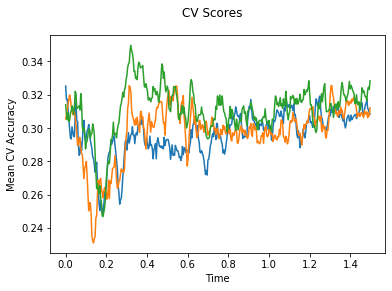

In [16]:
clf_UN = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_UN = SlidingEstimator(clf_UN, scoring='accuracy') 
if np.isfinite(data_UN).all() == True and np.isnan(data_UN).any() == False:
    CV_score_time = cross_val_multiscore(sl_UN, data_UN, labels_UN, cv=3)
    print('Cross validation scores:\n {}'.format(CV_score_time))
    plotCVScores(epochs_UN.times, CV_score_time)
else:
    print('Input contains NaN or infinity!')

### Task #3: Classification of Neutral and Pleasant Events

In [19]:
#Preparing dataset
data_NP, labels_NP, ids_NP = getData_labels(epochs_all_NP)

[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
Cross validation scores:
 [[0.44455923 0.4411157  0.44524793 ... 0.44249311 0.44421488 0.44283747]
 [0.44574578 0.44815708 0.44161213 ... 0.43678953 0.43506717 0.43575611]
 [0.44068966 0.44103448 0.44482759 ... 0.44068966 0.44068966 0.43931034]]


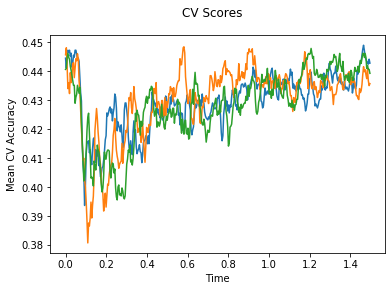

In [20]:
clf_NP = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
sl_NP = SlidingEstimator(clf_NP, scoring='accuracy') 
if np.isfinite(data_NP).all() == True and np.isnan(data_NP).any() == False:
    CV_score_time = cross_val_multiscore(sl_NP, data_NP, labels_NP, cv=3)
    print('Cross validation scores:\n {}'.format(CV_score_time))
    plotCVScores(epochs_NP.times, CV_score_time)
else:
    print('Input contains NaN or infinity!')

The above three plots show the mean cross validation accuracy over time for each classification task. The accuracies are less than 50% for all time points meaning that models do not perform above chance. This result may be caused by high variation between participants. To confirm this, participant level testing will be done as well. 

#### Analysis on temporal dimensions for each participant separately

1. Prepare data for the analysis

In [21]:
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]

In [22]:
epochs = [mne.read_epochs(f, verbose=False) for f in files]
epochs_UN = [e['FU', 'FN'] for e in epochs]
epochs_UP = [e['FU', 'FP'] for e in epochs]
epochs_NP = [e['FN', 'FP'] for e in epochs]
# Dataset with unpleasant and neutral events
data_UN = [e.get_data() for e in epochs_UN]
labels_UN = [e.events[:,-1] for e in epochs_UN]

data_UP = [e.get_data() for e in epochs_UP]
labels_UP = [e.events[:,-1] for e in epochs_UP]

data_NP = [e.get_data() for e in epochs_NP]
labels_NP = [e.events[:,-1] for e in epochs_NP]

2. Train classifiers with sliding window estimator on data of each participant separately and apply 3-fold cross validation.

In [23]:
def applyCrossValidation(data, labels, epochs, classifier):
    CV_score_time = None
    sl = SlidingEstimator(classifier, scoring='accuracy') 
    if np.isfinite(data).all() == True and np.isnan(data).any() == False:
        CV_score_time = cross_val_multiscore(sl, data, labels, cv=3)
        plotCVScores(epochs.times, CV_score_time)
    else:
        print('Input contains NaN or infinity!')
    return CV_score_time

#### Classification Between Unplesant and Neutral Events

Participant id: 0
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


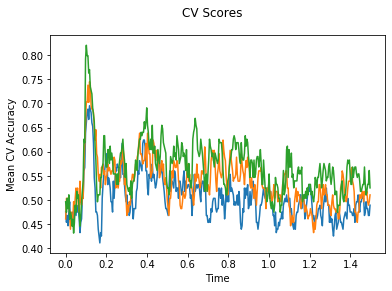

Participant id: 1
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


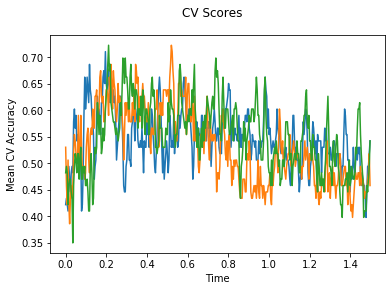

Participant id: 2
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


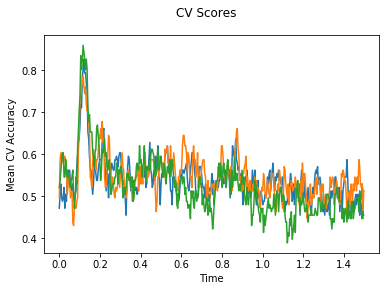

Participant id: 3
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


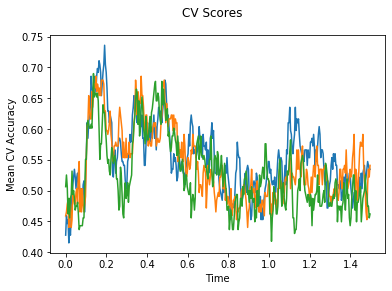

Participant id: 4
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


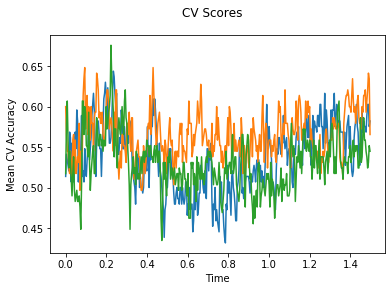

Participant id: 5
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


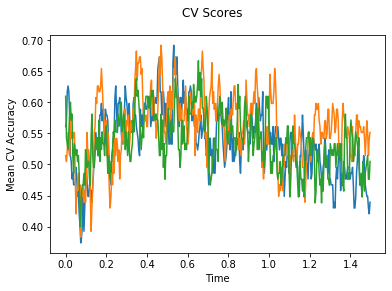

Participant id: 6
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


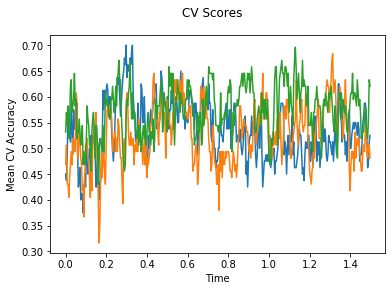

Participant id: 7
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


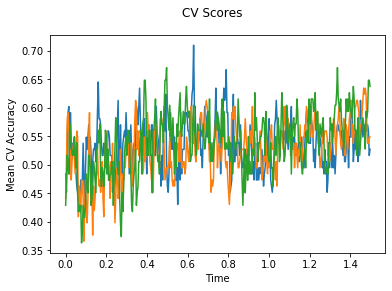

Participant id: 8
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


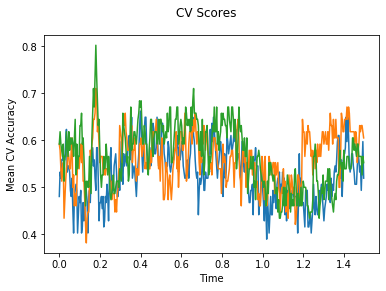

Participant id: 9
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


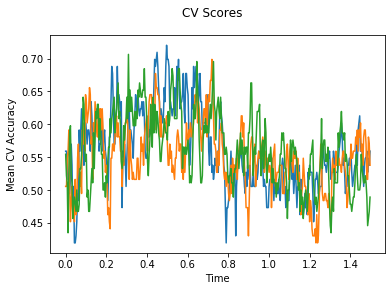

Participant id: 10
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


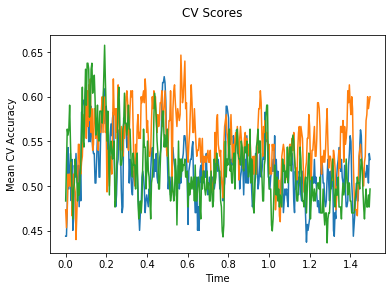

Participant id: 11
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


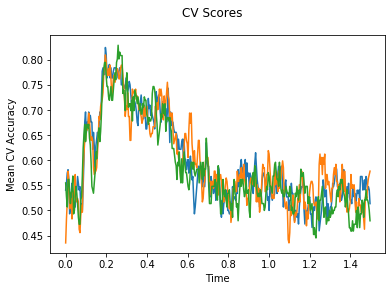

Participant id: 12
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


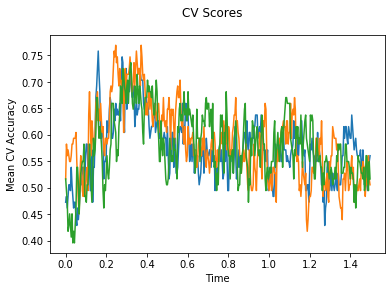

Participant id: 13
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


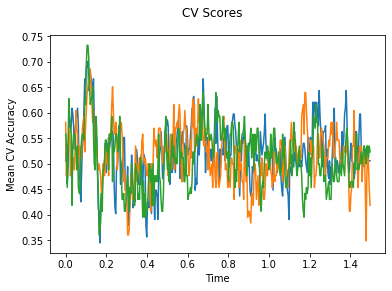

Participant id: 14
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


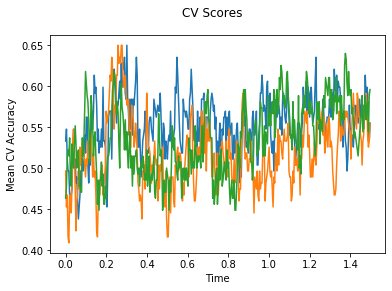

Participant id: 15
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


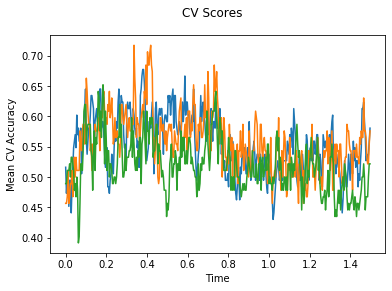

Participant id: 16
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


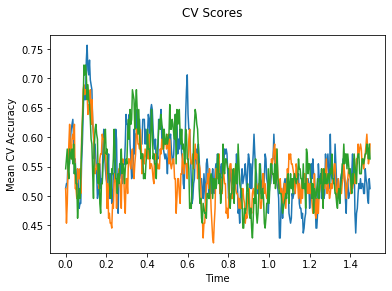

Participant id: 17
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


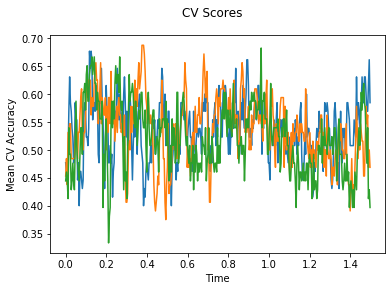

Participant id: 18
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


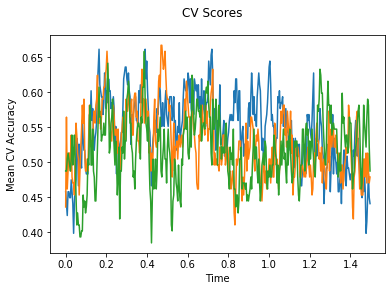

Participant id: 19
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


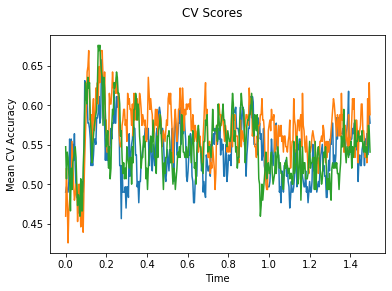

Participant id: 20
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


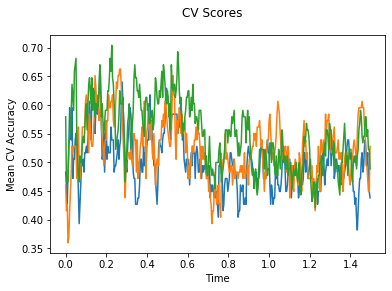

Participant id: 21
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


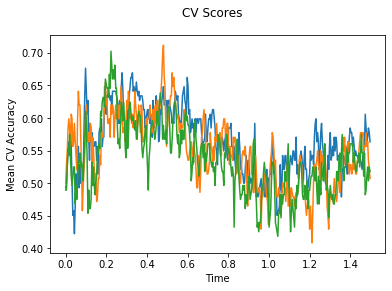

Participant id: 22
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


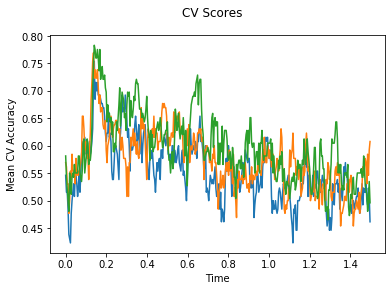

Participant id: 23
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


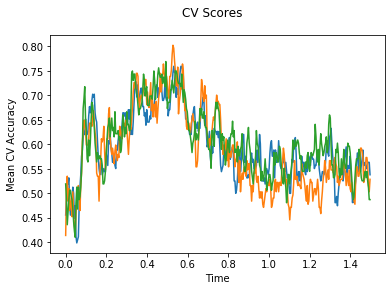

Participant id: 24
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  
[........................................] 100.00% Fitting SlidingEstimator |  


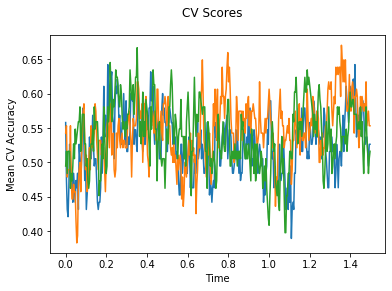

In [24]:
CV_score_time_UN = []
for i in range(len(data_UN)):
    print('Participant id: '+ str(i))
    clf = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    CV_score_time_UN.append(applyCrossValidation(data_UN[i], labels_UN[i], epochs_UN[i], clf))

In [29]:
def averageCVScores(CV_score_time):
    avg_cv_scores = []
    for cv in CV_score_time:
        avg_scores_tmp = []
        sum_col_wise = cv.sum(axis=0)
        avg_scores_tmp = [s/len(cv) for s in sum_col_wise]
        avg_cv_scores.append(avg_scores_tmp)
    return avg_cv_scores

In [30]:
avg_cv_score_time = averageCVScores(CV_score_time_UN)

The following cell plots the mean and standard deviation of cross validation accuracies of participants. 

In [52]:
import pylab, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from scipy.stats import ttest_rel, sem

def plot_conditions(data,epochs,labels):

    sns.set(style="white")
    ColorsL = np.array(([228,26,28], [55,126,184], [77,175,74], [152,78,163], [255,127,0]))/256
    col_axes = np.array((82, 82, 82))/256

    al = 0.2
    fig = plt.figure(num=None, figsize=(4, 2), dpi=150)

    
    epochs_mean = np.mean(data, axis = 0)
    epochs_std = sem(data, axis = 0)/2

    plt.plot(epochs[0].times, epochs_mean, color = ColorsL[0], linewidth = 2, label = labels)
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean + epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.fill_between(epochs[0].times, epochs_mean, epochs_mean - epochs_std, color = ColorsL[0], interpolate=True, alpha = al)
    plt.ylabel('Mean CV Accuracy')
    plt.xlabel('Times')

In contrast to the group-level cross validation plots, the mean of cross validation scores for all participants over time is higer than 50%. So, we may conclude that the variation between participants leads to poor performance on group-level.

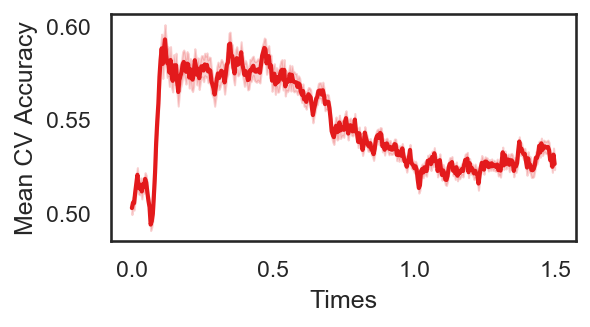

In [53]:
avg_cv_score_time = np.asarray(avg_cv_score_time)
plot_conditions(avg_cv_score_time,epochs_UN, labels_UN)

How do you improve the results?

Exercise: Apply filtering and also parameter optimization for LDA classifier to see the potential effects